In [1]:
from re import compile

from numpy import arange
from pandas import read_csv, DataFrame
from scipy.stats import ttest_rel
from seaborn import set_style, color_palette, lineplot, FacetGrid, histplot, set_theme

In [2]:
def target_f1(name: str) -> float:
    parts = name.split(" + ")
    for part in parts:
        if part.startswith("randomize"):
            match = compile(r"randomize\(F1<=(.*)\)").match(part)
            if not match:
                return 1.0
            return float(match.group(1))
    return 1.0

In [3]:
df: DataFrame = read_csv("data/metrics-reranking-all-f1.perquery.csv")
df["run"] = df["name"].apply(lambda name: name.split(" + ")[0])
df["team"] = df["run"].apply(lambda run: run.split(" ")[0])
df["target_f1"] = df["name"].apply(target_f1).fillna(1)
df.to_csv("data/tmp.csv")
df

,name,name_index,qid,nDCG@5 rel.,nDCG@5 qual.,alpha_nDCG@5 rel.,alpha_nDCG@5 qual.,F1@5,rKL@5,rND@5,rRD@5,run,team,target_f1
0,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1,100,0.170,0.170,0.197,0.197,0.136,0.192,0.727,0.61,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,1.00
1,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,2,100,0.339,0.339,0.394,0.394,1.000,1.000,0.978,1.00,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,1.00
2,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,3,100,0.339,0.339,0.394,0.394,0.946,1.000,0.978,1.00,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,0.95
3,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,4,100,0.339,0.339,0.394,0.394,0.900,1.000,0.978,1.00,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,0.90
4,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,5,100,0.339,0.339,0.394,0.394,0.847,1.000,0.978,1.00,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28595,Puss-in-Boots BM25-Baseline + ground-truth + r...,18,95,0.192,0.361,0.248,0.248,0.222,1.000,1.000,1.00,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.20
28596,Puss-in-Boots BM25-Baseline + ground-truth + r...,19,95,0.192,0.361,0.248,0.248,0.249,1.000,1.000,1.00,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.15
28597,Puss-in-Boots BM25-Baseline + ground-truth + r...,20,95,0.192,0.361,0.248,0.248,0.264,1.000,1.000,1.00,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.10
28598,Puss-in-Boots BM25-Baseline + ground-truth + r...,21,95,0.192,0.361,0.248,0.248,0.225,1.000,1.000,1.00,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.05


In [4]:
measure_columns = {
    "nDCG@5 rel.": r"nDCG@5 relevance",
    "nDCG@5 qual.": r"nDCG@5 quality",
    "alpha_nDCG@5 rel.": r"$\alpha$-nDCG@5 relevance",
    "alpha_nDCG@5 qual.": r"$\alpha$-nDCG@5 quality",
    # "rND@5": r"rND@5",
    # "rKL@5": r"rKL@5",
    # "rRD@5": r"rRD@5",
}
measure_columns

{'nDCG@5 rel.': 'nDCG@5 relevance',
 'nDCG@5 qual.': 'nDCG@5 quality',
 'alpha_nDCG@5 rel.': '$\\alpha$-nDCG@5 relevance',
 'alpha_nDCG@5 qual.': '$\\alpha$-nDCG@5 quality'}

In [5]:
teams = df[df["name_index"] == 1].groupby("team").aggregate("mean", numeric_only=True) \
    .sort_values("nDCG@5 rel.", ascending=False) \
    .sort_values("nDCG@5 rel.", ascending=False) \
    .reset_index()["team"] \
    .to_list()
teams = df

In [6]:
difference_data = []
for team in df["team"].unique():
    df_team = df[df["team"] == team]
    for run in df_team["run"].unique():
        df_run = df_team[df_team["run"] == run]
        df_baseline = df_run[df_run["name_index"] == 1]
        df_run = df_run[df_run["name_index"] != 1]
        for target_f1 in df_run["target_f1"].unique():
            df_target_f1 = df_run[df_run["target_f1"] == target_f1]
            for qid in df_target_f1["qid"].unique():
                df_qid_baseline = df_baseline[df_baseline["qid"] == qid]
                assert len(df_qid_baseline) == 1
                series_qid_baseline = df_qid_baseline.iloc[0]
                df_qid = df_target_f1[df_target_f1["qid"] == qid]
                assert len(df_qid) == 1
                series_qid = df_qid.iloc[0]
                for measure_column, measure_name in measure_columns.items():
                    difference = series_qid[measure_column] - series_qid_baseline[measure_column]
                    difference_data.append({
                        "team": team,
                        "run": run,
                        "target_f1": target_f1,
                        "measure": measure_name,
                        "qid": qid,
                        "difference": difference,
                    })
differences = DataFrame(difference_data)
differences

,team,run,target_f1,measure,qid,difference
0,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 relevance,100,0.169
1,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 quality,100,0.169
2,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,$\alpha$-nDCG@5 relevance,100,0.197
3,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,$\alpha$-nDCG@5 quality,100,0.197
4,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 relevance,12,0.022
...,...,...,...,...,...,...
109195,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.0,$\alpha$-nDCG@5 quality,93,0.156
109196,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.0,nDCG@5 relevance,95,0.000
109197,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.0,nDCG@5 quality,95,0.000
109198,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.0,$\alpha$-nDCG@5 relevance,95,0.000


In [7]:
significance_data = []
for team in df["team"].unique():
    df_team = df[df["team"] == team]
    for run in df_team["run"].unique():
        df_run = df_team[df_team["run"] == run]
        df_baseline = df_run[df_run["name_index"] == 1].sort_values("qid")
        df_run = df_run[df_run["name_index"] != 1]
        for target_f1 in df_run["target_f1"].unique():
            df_target_f1 = df_run[df_run["target_f1"] == target_f1].sort_values("qid")
            for measure_column, measure_name in measure_columns.items():
                p_value = ttest_rel(df_baseline[measure_column], df_target_f1[measure_column]).pvalue
                mean_improvement = df_target_f1[measure_column].mean() - df_baseline[measure_column].mean()
                if measure_name.startswith("r"):
                    mean_improvement = -mean_improvement
                significance_data.append({
                    "team": team,
                    "run": run,
                    "target_f1": target_f1,
                    "measure": measure_name,
                    "p_value": p_value,
                    "mean_improvement": mean_improvement,
                })
significances = DataFrame(significance_data)
significances

,team,run,target_f1,measure,p_value,mean_improvement
0,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.00,nDCG@5 relevance,0.000106,0.02792
1,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.00,nDCG@5 quality,0.001811,0.02770
2,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.00,$\alpha$-nDCG@5 relevance,0.000023,0.05346
3,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.00,$\alpha$-nDCG@5 quality,0.000023,0.05346
4,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,0.95,nDCG@5 relevance,0.000094,0.02822
...,...,...,...,...,...,...
2179,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.05,$\alpha$-nDCG@5 quality,0.717655,-0.00714
2180,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.00,nDCG@5 relevance,0.265787,-0.00798
2181,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.00,nDCG@5 quality,0.102994,-0.01042
2182,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.00,$\alpha$-nDCG@5 relevance,0.572577,-0.00716


In [8]:
first_bin = 0.2
last_bin = 1.00
bin_step = 0.05
bins = list(arange(
    first_bin - (bin_step / 2),
    last_bin + (bin_step / 2) + 0.0001,
    bin_step,
))
bins

[0.17500000000000002,
 0.22500000000000003,
 0.275,
 0.32500000000000007,
 0.3750000000000001,
 0.42500000000000016,
 0.4750000000000001,
 0.5250000000000001,
 0.5750000000000002,
 0.6250000000000002,
 0.6750000000000003,
 0.7250000000000002,
 0.7750000000000002,
 0.8250000000000003,
 0.8750000000000002,
 0.9250000000000003,
 0.9750000000000003,
 1.0250000000000004]

In [9]:
width = 4

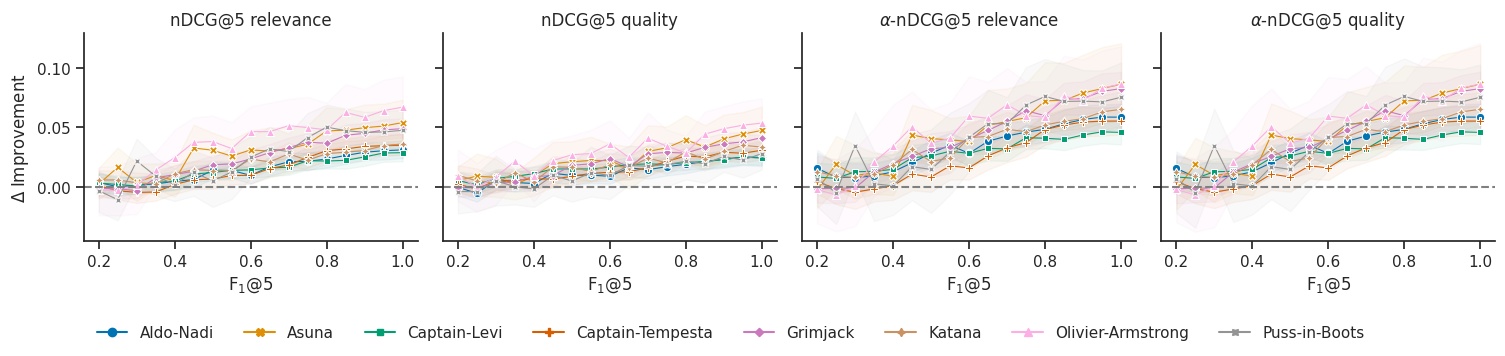

In [14]:
set_theme()
set_style("ticks")
aspect = 1.25
df_plot_differences = differences.copy()
df_plot_differences = df_plot_differences[df_plot_differences["target_f1"] >= first_bin]
plot_differences = FacetGrid(
    data=df_plot_differences,
    col="measure",
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_differences.map_dataframe(
    lineplot,
    x="target_f1",
    y="difference",
    hue="team",
    hue_order=df_plot_differences["team"].sort_values().unique(),
    palette=color_palette("colorblind")[:len(df_plot_differences["team"].unique())],
    markers=True,
    dashes=False,
    style="team",
    err_style="band",
    err_kws=dict(
        alpha=0.05,
    ),
    linewidth=0.8,
)
plot_differences.refline(y=0)
plot_differences.set_xlabels(r"F$_1$@5")
plot_differences.set_ylabels(r"$\Delta$ Improvement")
plot_differences.add_legend(
    loc="upper center",
    ncols=len(df_plot_differences["team"].unique()),
    bbox_to_anchor=(0.28, 0),
)
plot_differences.set_titles(col_template="{col_name}")
plot_differences.savefig("data/plot-reranking-f1-difference-best-run.pdf", transparent=True)
plot_differences.savefig("data/plot-reranking-f1-difference-best-run.png")
plot_differences

In [11]:
num_comparisons_per_run = 3

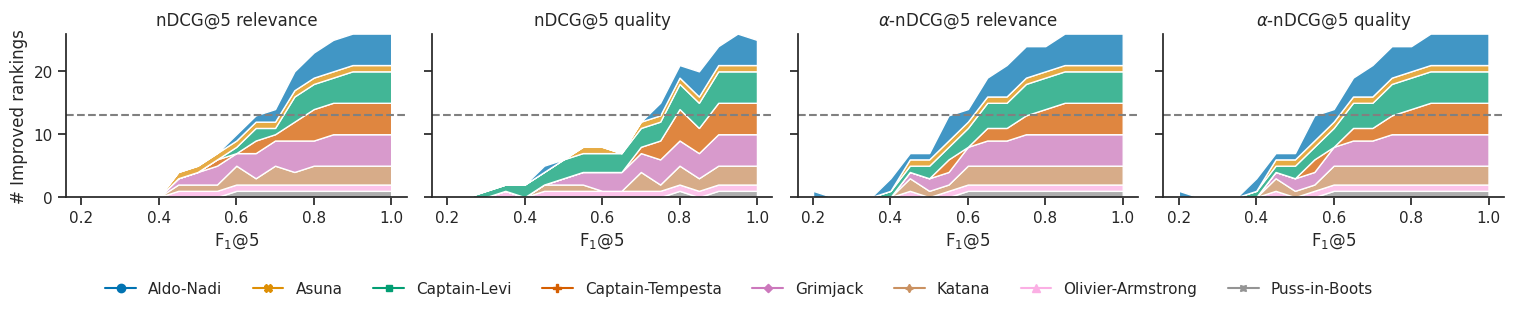

In [13]:
set_theme()
set_style("ticks")
aspect = 1.45
df_plot_significances = significances.copy()
df_plot_significances = df_plot_significances[df_plot_significances["mean_improvement"] > 0]
df_plot_significances = df_plot_significances[df_plot_significances["p_value"] < (0.05 / num_comparisons_per_run)]
plot_significances = FacetGrid(
    data=df_plot_significances,
    col="measure",
    ylim=(0, 26),
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_significances.map_dataframe(
    histplot,
    element="poly",
    x="target_f1",
    hue="team",
    hue_order=df_plot_significances["team"].sort_values().unique(),
    palette=color_palette("colorblind")[:len(df_plot_significances["team"].unique())],
    bins=bins,
    multiple="stack",
)
plot_significances.refline(y=len(df["run"].unique()) / 2)
plot_significances.set_ylabels(r"# Improved rankings")
plot_significances.set_xlabels(r"F$_1$@5")
plot_significances.add_legend(
    legend_data=plot_differences._legend_data,
    ncols=len(df_plot_significances["team"].unique()),
    loc="upper center",
    bbox_to_anchor=(0.28, 0),
)
plot_significances.set_titles(col_template="{col_name}")
plot_significances.savefig("data/plot-reranking-f1-num-significant-runs.pdf", transparent=True)
plot_significances.savefig("data/plot-reranking-f1-num-significant-runs.png")
plot_significances